# Import libraries and modules

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from LSTM_module import StockLSTM
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('../Datasets'))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset_creation import StockDataset

# Load Dataset

In [17]:
base_path = "../price/raw"
df = pd.read_csv(f"{base_path}/AAPL.csv")
print(len(df))

1258


In [18]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [20]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,0.362825,0.364963,0.367482,0.375340,87.121140,0.227562
1,2012-09-05,0.375638,0.366566,0.374189,0.369085,86.509338,0.205288
2,2012-09-06,0.372504,0.369136,0.375768,0.377055,87.288956,0.244032
3,2012-09-07,0.378878,0.374685,0.382305,0.382558,87.827171,0.200546
4,2012-09-10,0.382012,0.375758,0.364325,0.359201,85.542564,0.312446


# Prepare dataset

In [21]:
feature_columns = ['Open','High','Low','Close','Volume']
# feature_columns = ['Close']
filtered_df = df[feature_columns]
seq_len = 10
train_size = int(len(filtered_df) * 0.8)
train_data = filtered_df.iloc[:train_size]
test_data = filtered_df.iloc[train_size:]


In [22]:
try:
    train_dataset = StockDataset(train_data, seq_len, feature_columns)
    test_dataset = StockDataset(test_data, seq_len, feature_columns)
    print("Datasets created successfully!")
except Exception as e:
    print(f"Error creating dataset: {e}")

Datasets created successfully!


In [23]:
train_dataset[0]

(tensor([[0.3628, 0.3650, 0.3675, 0.3753, 0.2276],
         [0.3756, 0.3666, 0.3742, 0.3691, 0.2053],
         [0.3725, 0.3691, 0.3758, 0.3771, 0.2440],
         [0.3789, 0.3747, 0.3823, 0.3826, 0.2005],
         [0.3820, 0.3758, 0.3643, 0.3592, 0.3124],
         [0.3620, 0.3583, 0.3570, 0.3564, 0.3237],
         [0.3642, 0.3580, 0.3563, 0.3685, 0.4709],
         [0.3780, 0.3787, 0.3810, 0.3859, 0.3904],
         [0.3944, 0.3939, 0.3982, 0.3969, 0.3919],
         [0.4067, 0.3976, 0.4071, 0.4081, 0.2489]]),
 tensor(0.4109))

In [24]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Hyper-parameter tuning


In [31]:

import os
results_dir = "results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Define grid search parameters
hidden_sizes = [64, 128,256]
num_layers_options = [2, 3, 4]
batch_sizes = [16, 32,64]
grid_epochs = 20
input_size = len(feature_columns)

best_result=[]
current_best_loss=1000000

# Loop over all combinations
for hs in hidden_sizes:
    for nl in num_layers_options:
        for bs in batch_sizes:
            # Re-create DataLoaders for current batch size
            train_loader_grid = DataLoader(train_dataset, batch_size=bs, shuffle=True)
            test_loader_grid = DataLoader(test_dataset, batch_size=bs, shuffle=False)
            
            # Initialize model with current grid parameters
            model = StockLSTM(input_size=input_size, hidden_size=hs, num_layers=nl)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
            
            train_losses = []
            avg_test_loss = []
            for epoch in range(grid_epochs):
                model.train()
                epoch_losses = []
                for inputs, targets in train_loader_grid:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), targets)
                    loss.backward()
                    optimizer.step()
                    epoch_losses.append(loss.item())
                avg_loss = sum(epoch_losses) / len(epoch_losses)
                train_losses.append(avg_loss)
            
                # Evaluate the model on the grid test set
                model.eval()
                grid_predictions, grid_actuals, test_losses= [], [],[]
                with torch.no_grad():
                    for inputs, targets in test_loader_grid:
                        outputs = model(inputs)
                        grid_predictions.extend(outputs.squeeze().numpy())
                        grid_actuals.extend(targets.numpy())
                        loss = criterion(outputs.squeeze(), targets)
                        test_losses.append(loss.item())
                avg_test_loss.append(sum(test_losses) / len(test_losses))
            if avg_test_loss[-1]<current_best_loss:
                current_best_loss=avg_test_loss[-1]
                best_result=[hs,nl,bs]
        
            # Plot and save the training loss curve
            plt.figure(figsize=(10, 6))
            plt.plot(train_losses, label="Training Loss")
            plt.plot(avg_test_loss, label="Test Loss")
            plt.legend()
            plt.title(f"Losses (hidden_size={hs}, num_layers={nl}, batch_size={bs})")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            train_loss_filename = os.path.join(results_dir, f"loss_grid_hidden_size{hs}_num_layers{nl}_batch_size{bs}.png")
            plt.savefig(train_loss_filename)
            plt.close()
            
            # Plot and save the evaluation (predictions vs. actuals)
            plt.figure(figsize=(10, 6))
            plt.plot(grid_actuals, label="Actual Prices", marker="o")
            plt.plot(grid_predictions, label="Predicted Prices", marker="x")
            plt.title(f"Evaluation (hs={hs}, nl={nl}, bs={bs})")
            plt.xlabel("Time")
            plt.ylabel("Stock Price")
            plt.legend()
            eval_filename = os.path.join(results_dir, f"grid_evaluation_hs{hs}_nl{nl}_bs{bs}.png")
            plt.savefig(eval_filename)
            plt.close()
            
            print(f"Saved plots for hidden_size={hs}, num_layers={nl}, batch_size={bs}")
print("Best results are: ",best_result)
print("Best loss is: ",current_best_loss)

Saved plots for hidden_size=64, num_layers=2, batch_size=16
Saved plots for hidden_size=64, num_layers=2, batch_size=32
Saved plots for hidden_size=64, num_layers=2, batch_size=64
Saved plots for hidden_size=64, num_layers=3, batch_size=16
Saved plots for hidden_size=64, num_layers=3, batch_size=32
Saved plots for hidden_size=64, num_layers=3, batch_size=64
Saved plots for hidden_size=64, num_layers=4, batch_size=16
Saved plots for hidden_size=64, num_layers=4, batch_size=32
Saved plots for hidden_size=64, num_layers=4, batch_size=64
Saved plots for hidden_size=128, num_layers=2, batch_size=16
Saved plots for hidden_size=128, num_layers=2, batch_size=32
Saved plots for hidden_size=128, num_layers=2, batch_size=64
Saved plots for hidden_size=128, num_layers=3, batch_size=16
Saved plots for hidden_size=128, num_layers=3, batch_size=32
Saved plots for hidden_size=128, num_layers=3, batch_size=64
Saved plots for hidden_size=128, num_layers=4, batch_size=16
Saved plots for hidden_size=128, 

# Model initialization

In [25]:
input_size = len(feature_columns)
hidden_size = 128
num_layers = 3

model = StockLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/100, Training Loss: 0.16796735068783164, Eval Loss : 0.2888559754937887
Epoch 2/100, Training Loss: 0.05293293803697452, Eval Loss : 0.032293257652781904
Epoch 3/100, Training Loss: 0.022807881439803168, Eval Loss : 0.022009121370501816
Epoch 4/100, Training Loss: 0.011167448144988157, Eval Loss : 0.002596292266389355
Epoch 5/100, Training Loss: 0.002778912041321746, Eval Loss : 0.003784535816521384
Epoch 6/100, Training Loss: 0.0018965784870488278, Eval Loss : 0.00286426478123758
Epoch 7/100, Training Loss: 0.0017667852916929405, Eval Loss : 0.0018373637576587498
Epoch 8/100, Training Loss: 0.0016294788620143663, Eval Loss : 0.0016462977800983936
Epoch 9/100, Training Loss: 0.0014413481949304696, Eval Loss : 0.0011379499264876358
Epoch 10/100, Training Loss: 0.0013157587727619102, Eval Loss : 0.0009746476425789297
Epoch 11/100, Training Loss: 0.0012501168312155642, Eval Loss : 0.001196754616103135
Epoch 12/100, Training Loss: 0.0012080663109372836, Eval Loss : 0.00083444774645

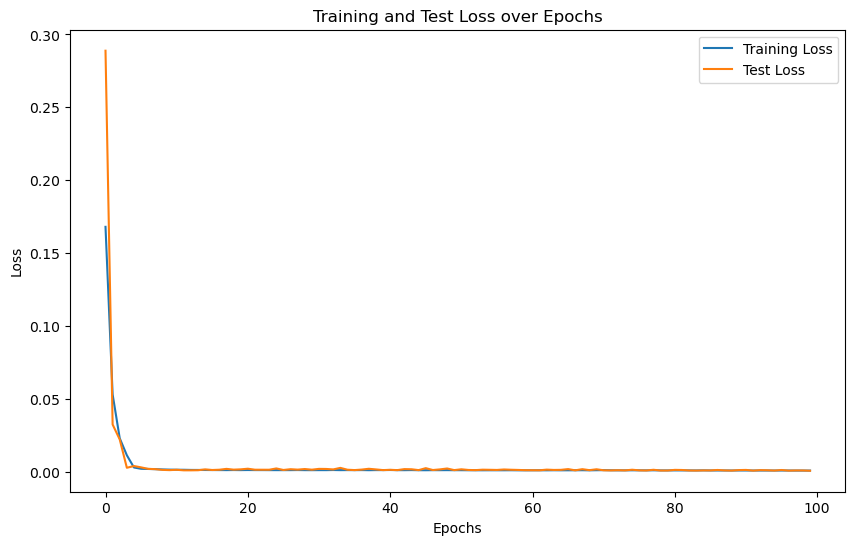

In [26]:
epochs = 100
per_epoch_train_losses = []
per_epoch_test_losses = []
for epoch in range(epochs):
    model.train()
    training_loss = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        # Test the model
    model.eval()
    predictions, actuals, test_losses = [], [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().numpy())
            actuals.extend(targets.numpy())
    # Calculate loss
            test_loss = criterion(torch.tensor(predictions), torch.tensor(actuals))
            test_losses.append(test_loss.item())
    avg_train_loss = sum(training_loss) / len(training_loss)
    avg_test_loss = sum(test_losses) / len(test_losses)
    per_epoch_train_losses.append(avg_train_loss)
    per_epoch_test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}, Eval Loss : {avg_test_loss}")
plt.figure(figsize=(10, 6))
plt.plot(per_epoch_train_losses, label='Training Loss')
plt.plot(per_epoch_test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()

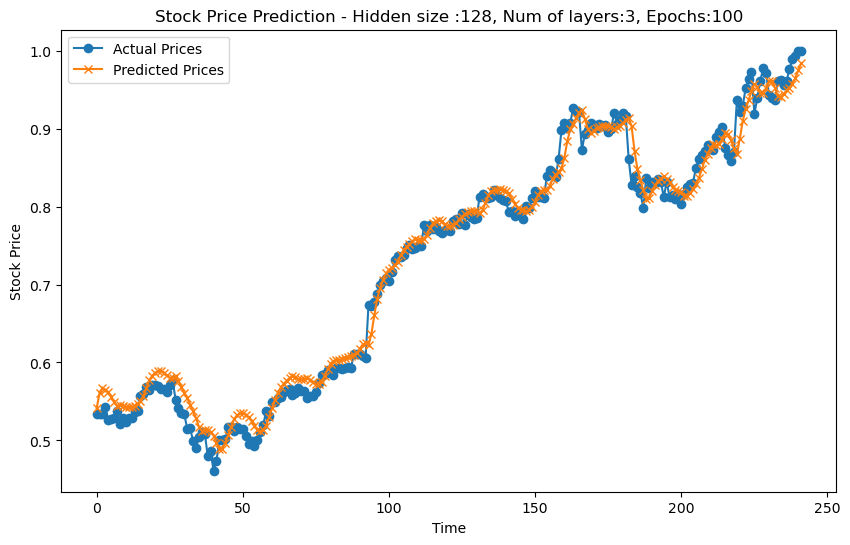

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Prices', marker='o')
plt.plot(predictions, label='Predicted Prices', marker='x')
plt.title(f'Stock Price Prediction - Hidden size :{hidden_size}, Num of layers:{ num_layers}, Epochs:{epochs}')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
